# Overview

#### Table of Contents
1. [Imports](#imports)
2. [EDA](#eda)
3. [Define functions](#functions)
4. [Modeling](#modeling)
    - IQR
    - IForest
    - XGBoost without Prophet predictions
    - XGB with Prophet predictions
    - XGB with Prophet predictions and lagged features

### Imports
<a id='imports'></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score
)
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
pd.options.display.float_format = '{:20,.2f}'.format
from prophet import Prophet
import seaborn as sns
from energy_anom_functions import *


In [ ]:
test = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\test.csv")
train = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\train.csv")
test_features = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\test_features.csv")
train_features = pd.read_csv(r"C:\Users\mcdonnelldeclan\Downloads\train_features.csv")

# convert timestamp to datetime format
test_features['timestamp'] = pd.to_datetime(test_features['timestamp'])
train_features['timestamp'] = pd.to_datetime(train_features['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['timestamp'] = pd.to_datetime(train['timestamp'])

### EDA
<a id='EDA'></a>

Shown below:
- Dataset contains 200 unique buildings, with hourly meter_readings for all of 2016
- 2.1% of meter_readings are anomaly
- Many feature columns are highly correlated so can be dropped
- Only meter_reading has missing values

Other info not shown:
- Some features have likely null values represented by other numbers (year_built, cloud_coverage = 255, wind_direction = 65535)
- For hours with missing meter_readings, none are marked as anomaly
- For meter_readings == 1.0, they are all anomaly. 45% of all anomalies are meter_readings of 1.0

### Column Descriptions


|Building features|Weather features|Time based features|Log transformed interactions|
|-----------------|----------------|-------------------|----------------------------|
| building_id: 200 unique 	    | air_temperature: 620 unique                   | hour: 24 unique	    | building_weekday_hour: 33600 unique. can drop these interactions
| timestamp: 8784 unique 	    | cloud_coverage: 11 unique vals. 255 isna, most common	| weekday: 7 unique	| building_weekday: 1400 unique
| meter_reading: 191681 unique 	| dew_temperature: 523 unique			        | month: 12 unique	    | building_month: 2400 unique
| anomaly: 2 unique vals	        | precip_depth_1_hr: 128 unique			    | year: 1 unique	    | building_hour: 4800 unique
| site_id: geographic siting, 14 unique	    | sea_level_pressure: 710 unique	| weekday_hour: 168 unique	    | building_meter: 200 unique
| primary_use: building type usage, 12 unique	| wind_direction: 44 unique		| hour_x: 13 unique. Cyclic encoded 	| is_holiday: 2 unique
| square_feet: 200 unique	    | wind_speed: 59 unique. 65535 isna             | hour_y: 13 unique	        | gte_hour: avg of log1p of meter reading per hour. 24 unique.
| year_built: 1900 + year built value. 32 unique. 255 isna | air_temperature_mean_lag7: 3786 unique	| month_x: 1477 unique vals	| gte_weekday: 7 unique
| floor_count: 12 unique	    | air_temperature_max_lag7: 3811 unique	        | month_y: 1477 unique	    | gte_month: 12 unique
|                                   | air_temperature_min_lag7: 3834 unique	    | weekday_x: 85 unique	| gte_building_id: 195 unique
|                                   | air_temperature_std_lag7: 3397 unique	    | weekday_y: 85 unique	| gte_primary_use: 12 unique
|                                   | air_temperature_mean_lag73: 9284 unique	|                   | gte_site_id: 14 unique
|                                   | air_temperature_max_lag73: 1948 unique	|                   | gte_meter: avg of log1p of meter reading. 1 unique
|                                   | air_temperature_min_lag73: 1927 unique	|                   | gte_meter_hour: 23 unique
|                                   | air_temperature_std_lag73: 3404 unique	|                   | gte_meter_weekday: 6 unique
|                                   |                                           |                   | gte_meter_month: 11 unique
|                                   |                                           |                   | gte_meter_building_id: 197 unique
|                                   |                                           |                   | gte_meter_primary_use: 12 unique
|                                   |                                           |                   | gte_meter_site_id: 14 unique
|                                   |                                           |                   | gte_meter_building_id_hour: 2949 unique
|                                   |                                           |                   | gte_meter_building_id_weekday: 1180 unique
|                                   |                                           |                   | gte_meter_building_id_month: 1853 unique


In [46]:
# What dates is the dataset for?
    # All of 2016
train.timestamp.max()

Timestamp('2016-12-31 23:00:00')

In [47]:
# what is the time interval?
    # hourly, with no missing data or outliers (8784 hourly readings = 366 days in the year))
timestamps = train['timestamp'].drop_duplicates().diff()
timestamps.describe()

count               8783
mean     0 days 01:00:00
std      0 days 00:00:00
min      0 days 01:00:00
25%      0 days 01:00:00
50%      0 days 01:00:00
75%      0 days 01:00:00
max      0 days 01:00:00
Name: timestamp, dtype: object

In [48]:
# how many buildings in the dataset?
    # 200 buildings, around half with all readings, and a minimum of ~311 days (7471 hourly readings)
train['building_id'].value_counts(sort=True).describe()

count                 200.00
mean                8,747.47
std                   152.85
min                 7,471.00
25%                 8,766.00
50%                 8,783.00
75%                 8,784.00
max                 8,784.00
Name: count, dtype: float64

In [49]:
# how many anomalous datapoints?
    # 37296, or 2.1%
train.value_counts(subset='anomaly')

anomaly
0    1712198
1      37296
Name: count, dtype: int64

In [ ]:
# missing values for features
    # only meter reading is missing
for col in train_features.columns:
    cols_na = train_features[col].isna().sum()
    if cols_na > 0:
        print(f'{col}: {cols_na}')

meter_reading: 107653


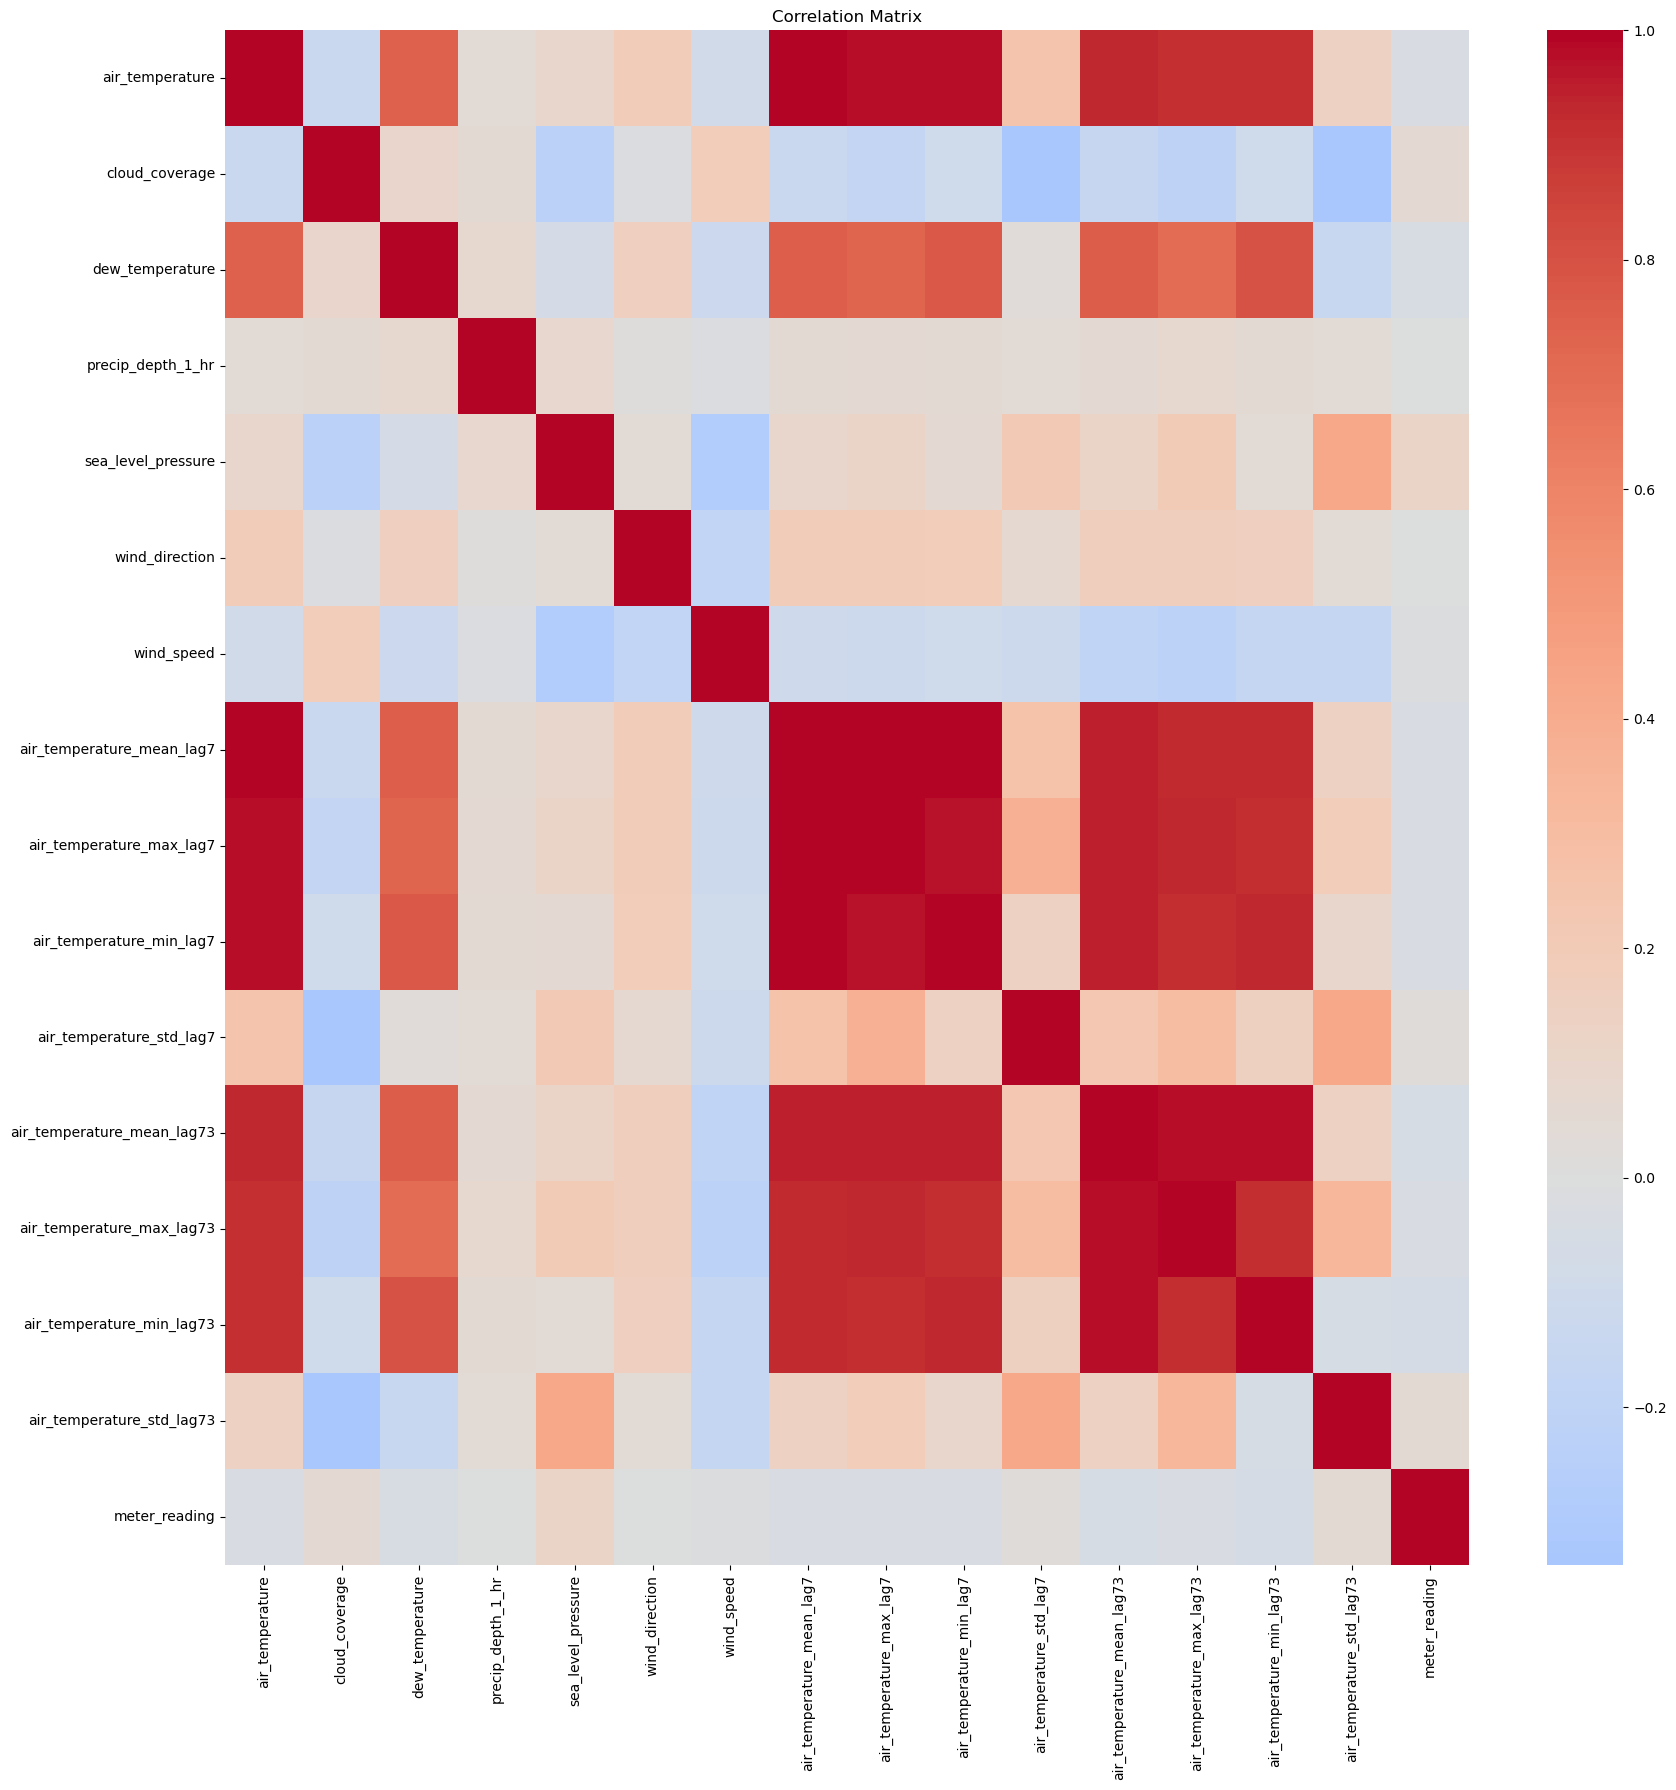

In [ ]:
# Correlation columns to see what features can be removed:
corr_cols_to_check = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73',]

corrs = train_features[corr_cols_to_check + ['meter_reading']].corr()
# Basic correlation heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corrs, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


### Define functions
<a id='functions'></a>
- **plot_anomalies**: Take any building you want and plot what it looks like with the predicted anomalies and/or predicted meter_readings labeled
- **eval_metrics**: Take a dataframe with predicted anomalies and calculate the accuracy, precision, recall, F1 score, and AUC
- **evaluate_ts_predictions**: For time series model, determine the MAPE
- **create_submission_df**: Takes test dataframe with anomaly score predictions and prepares columns needed to submit to Kaggle
- **label_anomalies_iqr**: Takes a dataset of buildings and meter readings. For each building, calculates Q3/Q1/IQR and upper/lower limits of where outliers are. It then uses those limits to label a new column called pred_anomaly_iqr as 1/0.
- **anomalies_iqr**: Create a pred_anomaly_iqr label using the IQR to determine outliers
- **iforest_model**: Takes the train dataframe and builds an iforest model for each building
- **feature_preparation**:
    - impute columns / add 1/0 categorical columns for missing data if columns are used
    - drop columns not needed
    - optional param to drop additional columns
- **xgb_model_custom**: Train and fit an XGB model, and return evaluation metrics
- **add_zscore_col**: Using Prophet, predict what the meter reading should be, then create additional residual and residual_zscore column which is how many std the zscore is away from the rest of the bldg zscores
- **parallel_process_buildings**: Trains prophet model to predict meter readings for each individual building in parallel to improve speed

### Modeling
<a id='modeling'></a>
- Detect anomalies with IQR and evaluate with accuracy/precision/recall/F1 score
- Detect anomalies with Isolation Forest and evaluate with AUC and confusion matrix metrics

XGBoost: 
- first try small selection of featureset to do a simple baseline
- Then try with full featureset and feature cleaning
- Then try with added Prophet model predicted_meter_readings
- Then try with lagged features

In [53]:
# detect anomalies with IQR
train_with_anomalies = anomalies_iqr(train)

# evaluate
eval_metrics(train_with_anomalies, pred_anomaly='pred_anomaly_iqr')

Accuracy:  96.45 %
Recall:  29.15 %
Precision:  23.31 %
F1 Score:  25.91 %


In [54]:
# First Submission: Make predictions with Isolation Forest (Public Score: 0.72552; Private score: 0.73704)

# detect anomalies with Isolation Forest
iforest_df = iforest_model(train)

# evaluate
auc = roc_auc_score(iforest_df['anomaly'], iforest_df['anomaly_score'])
print('AUC: ', auc)
eval_metrics(iforest_df, pred_anomaly='pred_anomaly_iforest')

AUC:  0.7351596103278517
Accuracy:  96.91 %
Recall:  36.22 %
Precision:  30.82 %
F1 Score:  33.3 %


In [ ]:
# Predict on test set
iforest_df_test = iforest_model(test)

# Prep for submission
iforest_df_test_submit = create_submission_df(iforest_df_test)

NameError: name 'create_submission_df' is not defined

#### XGBoost

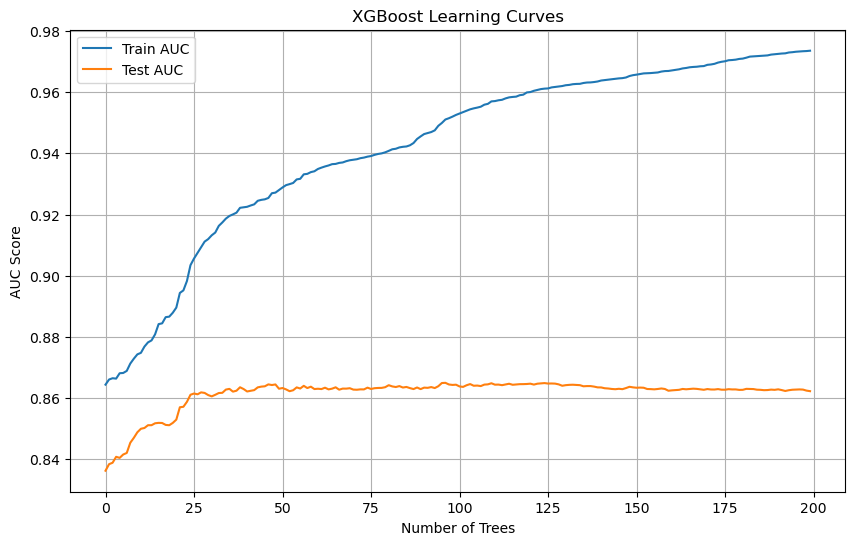

Best test AUC: 0.8650
Model Params: n_estimators=200, max_depth=9, learning_rate=0.1, smote=False
AUC:  0.8622868311725199
Accuracy:  98.42 %
Recall:  47.57 %
Precision:  77.8 %
F1 Score:  59.04 %


In [55]:
# Second submission - submission_2_xgb_simple.csv
    # XGBoost with ['building_id', 'meter_reading','air_temperature', 'hour','weekday', 'month','is_holiday'], (n_estimators=200, max_depth=9, learning_rate=0.1, objective='binary:logistic')
    # Public Score 0.86957, Private Score 0.90204

xgb_simple, train_df_with_xgb_simple_pred, cols_used_during_training = xgb_model_custom(df=train_features
                                                                                        , df_full=train_features
                                                                                        , cols_to_use=['meter_reading','air_temperature', 'hour','weekday', 'month','is_holiday']
                                                                                        , n_estimators=200, max_depth=9)

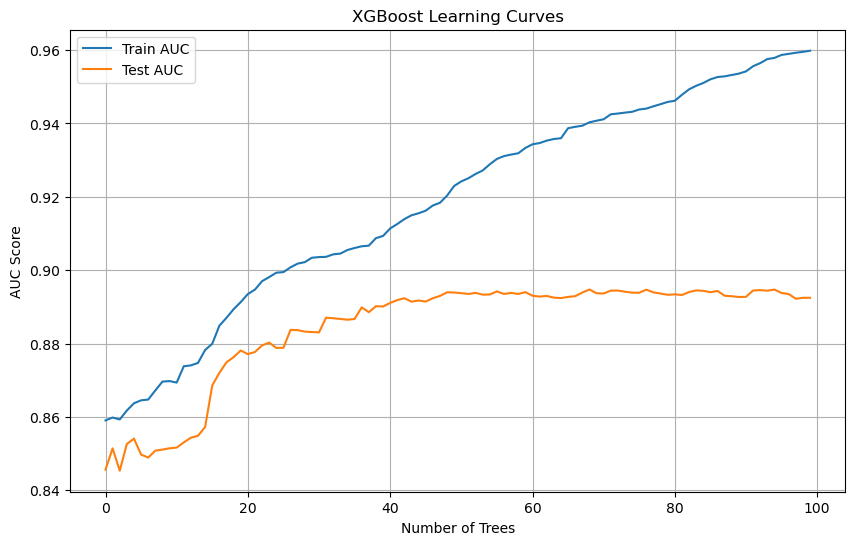

Best test AUC: 0.8947
Model Params: n_estimators=100, max_depth=5, learning_rate=0.1, smote=False
AUC:  0.892470815955611
Accuracy:  98.78 %
Recall:  56.54 %
Precision:  88.01 %
F1 Score:  68.85 %


In [56]:
# Third submission - 
    # XGBoost with full features besides single value, transformed, or hicorr; (n_estimators=100, max_depth=5, learning_rate=0.1, objective='binary:logistic')
    # Public Score 0.87824, Private Score 0.91776 

train_features_prepped = feature_preparation(train_features)

xgb_full, train_df_with_xgb_full_pred, feature_importance_df = xgb_model_custom(df = train_features_prepped
                                                                                    , df_full=train_features
                                                                                    , n_estimators=100
                                                                                    , max_depth=5)

In [ ]:
# Add predicted_meter_readings using Prophet model
train_features_zscore = parallel_process_buildings(train_features)
test_features_zscore = parallel_process_buildings(test_features)

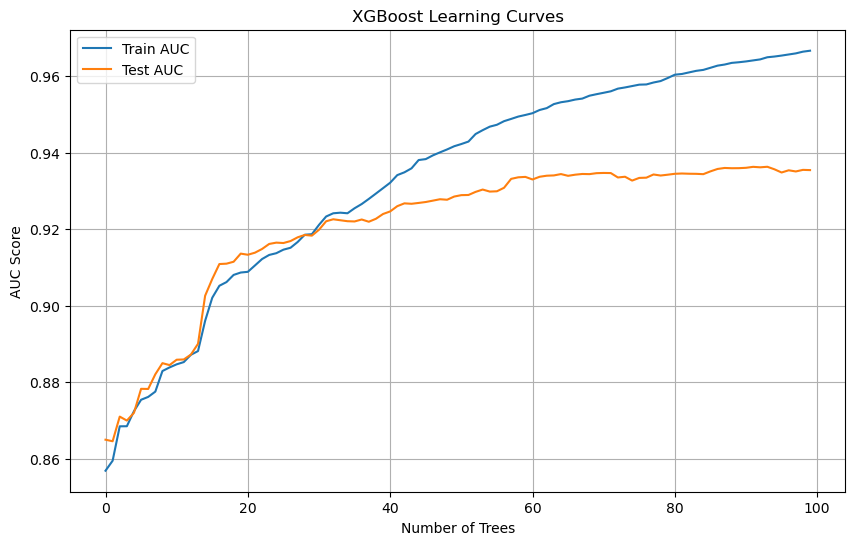

Best test AUC: 0.9363
Model Params: n_estimators=100, max_depth=5, learning_rate=0.1, smote=False
AUC:  0.9354133621112005
Accuracy:  98.94 %
Recall:  57.15 %
Precision:  97.78 %
F1 Score:  72.13 %


In [ ]:
# Fourth submission
    # XGBoost with residual_zscore + full features besides single value, transformed, or hicorr; (n_estimators=100, max_depth=5, learning_rate=0.1, objective='binary:logistic')
    # Public Score 0.90087, Private Score 0.92694 
df_train_with_zscore = feature_preparation(train_features_zscore)
xgb_custom_zscore, df_train_with_predictions_zscore, feature_importance_df_zscore = xgb_model_custom(df=df_train_with_zscore, df_full=final_df, n_estimators=100, max_depth=5)

In [59]:
# add lagged features for meter_reading_imputed and residual_zscore
final_df_lag = pd.DataFrame()
for building in train_features_zscore['building_id'].unique():
    building_df = train_features_zscore[train_features_zscore['building_id']==building].copy()
    #building_df.sort_values(by='timestamp', inplace=True)
    building_df['meter_reading_imputed_lag1'] = building_df['meter_reading_imputed'].shift(1)
    building_df['meter_reading_imputed_lag24'] = building_df['meter_reading_imputed'].shift(24)
    building_df['meter_reading_imputed_lag168'] = building_df['meter_reading_imputed'].shift(168)
    building_df['residual_zscore_lag1'] = building_df['residual_zscore'].shift(1)
    building_df['residual_zscore_lag2'] = building_df['residual_zscore'].shift(2)
    building_df['residual_zscore_lag3'] = building_df['residual_zscore'].shift(3)
    building_df['residual_zscore_lag24'] = building_df['residual_zscore'].shift(24)
    building_df['residual_zscore_lag168'] = building_df['residual_zscore'].shift(168)
    final_df_lag = pd.concat([final_df_lag, building_df], axis=0)


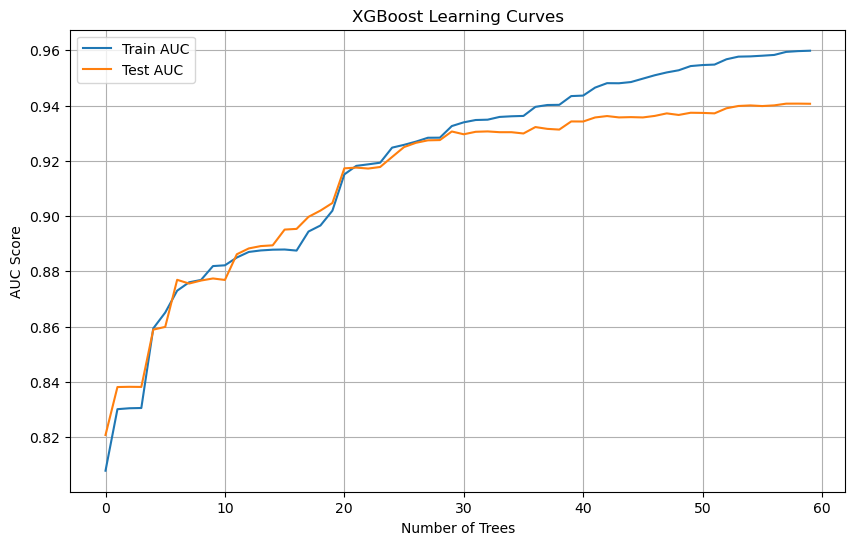

Best test AUC: 0.9407
Model Params: n_estimators=60, max_depth=5, learning_rate=0.1, smote=False
AUC:  0.9406447346104233
Accuracy:  99.01 %
Recall:  59.94 %
Precision:  97.52 %
F1 Score:  74.24 %


In [60]:
# Fifth submission - 
    # XGBoost with residual_zscore, lagged values, and full features besides single value, transformed, or hicorr; (n_estimators=100, max_depth=5, learning_rate=0.1, objective='binary:logistic')
    # Public Score 0.94025, Private Score 0.92147 
df_train_with_zscore_lag = feature_preparation(final_df_lag)
xgb_custom_zscore_lag, df_train_with_predictions_zscore_lag, feature_importance_df_zscore_lag = xgb_model_custom(df=df_train_with_zscore_lag, df_full=final_df_lag, n_estimators=60, max_depth=5)